# Mini Reto 004 del grupo Python para Trading

# Leer precios del chart de una página


Dada la siguiente URL:

http://www.rava.com/empresas/perfil.php?e=Mirg

![Chart Web](../../Chart_Web.png)


#### Obtener los precios de la web

Dicha web, muestra los precios de una empresa en una gráfica de velas. Analizar la página web para identificar la forma en que se solicitan los precios al servidor y manejar esos para poder cargarlos en un `DataFrame` y poder gestionarlos adecuadamente con Pandas. 

### Exportar Excel

Cabe mencionar que esta URL tiene una opcion para **descargar los precios historicos** en `.CSV` con tan solo pinchar en el botón que hay bajo el cuadro de precios historicos:

![Eportar Excel](../../Exportar_Excel.png)

Que nos lleva a:

http://www.rava.com/empresas/precioshistoricos.php?e=MIRG&csv=1


**Sin embargo**, se va a usar como ejemplo para un Mini Reto dónde no la web no proporcionase la forma de exportar los datos.

# Solución propuesta

En primer lugar vamos a analizar la URL. Una vez que la visitemos, vemos lo que aparece en la imagen del enunciado.

Para saber como obtiene los datos hay muchas alternativas. Lo primero es saber como trabajan este tipo de gráficas.

Estos componentes, suelen ser código en JavaScript que permite interactuar con el usuario, para permitir que mueva el ratón por el gráfico y realice acciones como mover las franjas de tiempo, agrandar, y demas opciones.

Para poder hacer esto, el código JavaScript, previamente ha debido cargar los precios, de forma que al redimensionas o cambiar los periodos de tiempo, no tiene que volver a pedir los precios al servidor, sino que los vuelve a mostrar como haya pedido el usuario. Esto evita saturación en el servidor y aumenta la velocidad con la que el usuario lo visualiza.

Para los que no estén familiarizados con HTML y/o protocolo HTTP, es dificil analizar las peticiones del servidor, pero hay una forma sencilla de hacerlo con el propio navegador.

Una vez esta cargada la página, pulsar la tecla **F12** Suele ser un estandar en cualquier navegador. Esto muestra un panel con muchos detalles técnicos de la página y el HTML. Vamos a pinchar sobre **Network** y luego volveremos a cargar la página **F5** para ver todas las conexiones que hacer el navegador con el servidor para mostrar los datos. Una vez hecho esto, ser verá algo parecido a lo siguiente:

![Chart Network](Chart_Network.png)

Si pinchamos sobre cada uno de los elementos, veremos si es una imagen `.png`, código `.js`, hojas de estilo `.css` u otros recursos. Lo que buscamos es un recurso dinámico, ya que los precios van cambiando. En este caso, es facil identificarlo porque ademas de ser el primer en cargar es un fichero `.php` que tienen contenido dinámico.


![Chart Perfil 01](Chart_perfil.php_01.png)

Si pinchamos sobre él, vemos la respuesta del servidor que es algo extensa, como es de esperar por la cantidad de conenido. Esto nos ayuda a localizarlo, ya que se puede ver que hay una barra verde a su derecha, que indica el tiempo de carga, y es superior al resto.

![Chart Perfil 02](Chart_perfil.php_02.png)


Ahora vamos a mirar por encima el contenido buscando una lista larga de precios, y vemos lo siguiente:

![Chart Perfil 03](Chart_perfil.php_03.png)


### Estrategia

Ahora que ya sabemos de donde solicita los datos, vamos a extraerlos mediante expresiones regulares, de forma que cada línea de precios pueda ser extraida e introducida en una lista que posteriormente sea convertido en un objeto `DataFrame` para poder manejar con Pandas.

In [171]:
import pandas as pd
import requests
import re
import numpy as np 

In [161]:
URL = 'http://www.rava.com/empresas/perfil.php?e=Mirg'
data = requests.get(URL).text

#### Diseño de la expresión regular

Las expersiones regulares son relativamente complicadas. Cuanto mas afinado quieras que sean los resultados, mas complicada deberá ser esta.

En general puede bastar con extraer las línes que contienen el `chartData.push(...);` y tratar de usar el contenido como un `json` en un bucle. Pero aunque esto puede ser mas claro y sencillo para quien no se maneje con expersiones regulares, es bastante ineficiente.

Lo que hace la expresion regular, es **crear varios grupos identificados por los parentesis**, de forma que en los resultados, por cada linea de coincidencia, **habran tantos elementos, como parentesis se hayan puesto**. Es por esto qe es importante escapar los parentesis que tenga el propio texto `\(` y `\)` para no confundirlos con los grupos de la expresión regular.

In [254]:
pattern = "chartData.push\(\{'date': '(\d\d\d\d-\d\d-\d\d)','open': (\w+.\w+),'close': (\w+.\w+),'high': (\w+.\w+),'low': (\w+.\w+),'volume': (\w+)\}\);"
matches = re.findall(pattern, data)
matches

[('2018-05-11', '520.00', '558.55', '569.00', '520.00', '18666'),
 ('2018-05-12', '570.00', '554.35', '570.00', '522.00', '16799'),
 ('2018-05-15', '550.00', '545.85', '550.00', '535.00', '15528'),
 ('2018-05-16', '550.00', '539.00', '568.00', '539.00', '12621'),
 ('2018-05-17', '563.00', '523.40', '563.00', '520.00', '17352'),
 ('2018-05-18', '533.95', '539.85', '548.00', '521.00', '16284'),
 ('2018-05-19', '550.00', '561.75', '581.00', '535.00', '13898'),
 ('2018-05-22', '563.00', '558.35', '575.00', '553.00', '7732'),
 ('2018-05-23', '559.00', '542.50', '563.00', '542.00', '5874'),
 ('2018-05-24', '532.00', '516.70', '535.00', '512.00', '12053'),
 ('2018-05-25', '516.20', '507.25', '520.00', '502.00', '10882'),
 ('2018-05-29', '508.00', '485.55', '516.00', '483.00', '10013'),
 ('2018-05-30', '495.00', '455.00', '495.00', '450.70', '22309'),
 ('2018-05-31', '455.00', '449.25', '472.00', '448.00', '13355'),
 ('2018-06-01', '460.00', '443.00', '460.00', '428.00', '33499'),
 ('2018-06-0

Ahora simplemente se usa esa lista de 6 elementos y se usar como valores para el `DataFrame` 

In [303]:
df = pd.DataFrame(np.array(matches),columns=['date','open','close','high','low','volume'])
df = df.set_index('date')
df.dtypes

open      object
close     object
high      object
low       object
volume    object
dtype: object

Para poder operar con los valores, se deben convertir a numéricos, ya que la expresión regular los ha devuelto como `string`

In [304]:
df = df[df.columns].astype(float)
df.dtypes

open      float64
close     float64
high      float64
low       float64
volume    float64
dtype: object

#### Comprobando los datos

Ahora vamos a hacer unas pequeñas comprobaciones de integridad de los datos.

Para que sean válidos deben cumplir que `low` sea el mas bajo y `high` el mas alto, para ellos, vamos a calcular  

In [305]:
df[df.high >= df.low].shape

(600, 5)

In [306]:
df[df.open >= df.low].shape

(600, 5)

In [307]:
df[df.close >= df.low].shape

(599, 5)

#### Datos erróneos

Ya que el número de rows es de 600, se observa como solo 599 cumplen la condicion de que `close` sea igual o mayor que `low` y con ese dato erróneo, basta para no poder pintar las velas.

Vemos cual es:

In [308]:
df[df.close < df.low]

,open,close,high,low,volume
date,,,,,
2020-03-17,615.0,530.0,620.0,565.0,8429.0


Podriamos tratar de arreglarlo, igualando `low` a `close` pero esto modificaría nuestros datos, así que habría que hacerlo con sumo cuidado y sabiendo que se estan ajustando los datos reales.

#### Visualizando los datos

Vamos a pintar los precios de apertura y cierre.

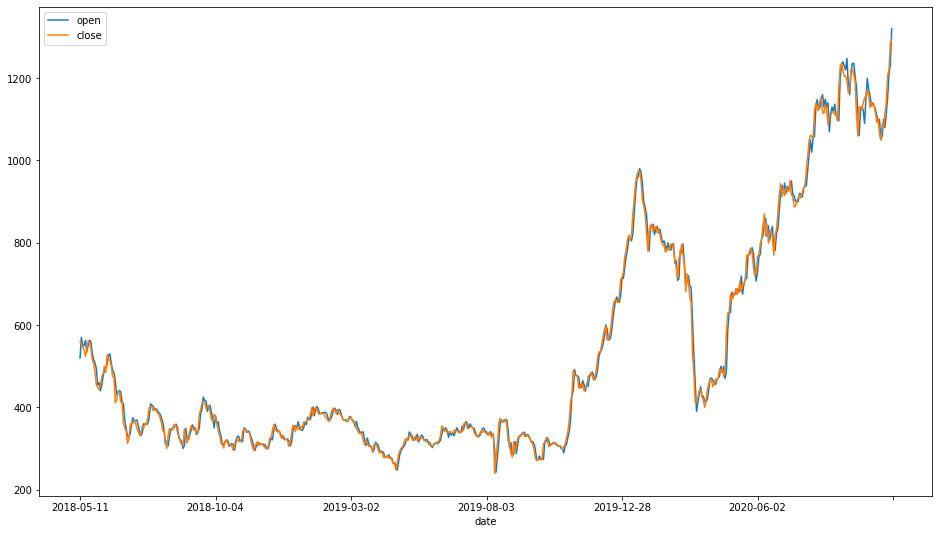

In [309]:
df[['open','close']].plot(figsize=(16,9))

#### Visualizando en gráficos de velas - CandleStick

Para evitar los datos errónes, vamos a pintar solo hasta el período 500.

In [310]:
import plotly.figure_factory
df = df.iloc[:450]
fig = plotly.figure_factory.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)
fig.show()